## POS tagging using modified Viterbi

### Data Preparation

In [1]:
#Importing libraries
import nltk
import random
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
nltk.download('universal_tagset')

[nltk_data] Downloading package universal_tagset to
[nltk_data]     /Users/triloknichlani/nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!


True

In [2]:
# reading the Treebank tagged sentences
nltk_data = list(nltk.corpus.treebank.tagged_sents(tagset='universal'))

In [3]:
print(nltk_data[:30])

[[('Pierre', 'NOUN'), ('Vinken', 'NOUN'), (',', '.'), ('61', 'NUM'), ('years', 'NOUN'), ('old', 'ADJ'), (',', '.'), ('will', 'VERB'), ('join', 'VERB'), ('the', 'DET'), ('board', 'NOUN'), ('as', 'ADP'), ('a', 'DET'), ('nonexecutive', 'ADJ'), ('director', 'NOUN'), ('Nov.', 'NOUN'), ('29', 'NUM'), ('.', '.')], [('Mr.', 'NOUN'), ('Vinken', 'NOUN'), ('is', 'VERB'), ('chairman', 'NOUN'), ('of', 'ADP'), ('Elsevier', 'NOUN'), ('N.V.', 'NOUN'), (',', '.'), ('the', 'DET'), ('Dutch', 'NOUN'), ('publishing', 'VERB'), ('group', 'NOUN'), ('.', '.')], [('Rudolph', 'NOUN'), ('Agnew', 'NOUN'), (',', '.'), ('55', 'NUM'), ('years', 'NOUN'), ('old', 'ADJ'), ('and', 'CONJ'), ('former', 'ADJ'), ('chairman', 'NOUN'), ('of', 'ADP'), ('Consolidated', 'NOUN'), ('Gold', 'NOUN'), ('Fields', 'NOUN'), ('PLC', 'NOUN'), (',', '.'), ('was', 'VERB'), ('named', 'VERB'), ('*-1', 'X'), ('a', 'DET'), ('nonexecutive', 'ADJ'), ('director', 'NOUN'), ('of', 'ADP'), ('this', 'DET'), ('British', 'ADJ'), ('industrial', 'ADJ'), ('

In [4]:
from sklearn.model_selection import train_test_split 

You can split the Treebank dataset into train and validation sets. Please use a sample size of 95:5 for training: validation sets, i.e. keep the validation size small, else the algorithm will need a very high amount of runtime.

In [5]:
random.seed(3456)
train, test = train_test_split(nltk_data, test_size=0.05)

In [6]:
print(len(train))
print(len(test))

3718
196


In [8]:
#tagged words
train_tagged_words = [tup for sent in train for tup in sent]
len(train_tagged_words)

95737

In [9]:
#tokens
tokens = [pair[0] for pair in train_tagged_words]
tokens[:10]

['The',
 'company',
 'said',
 'that',
 'because',
 'of',
 'softening',
 'sales',
 'it',
 'is']

In [10]:
#vocab
V = set(tokens)
print(len(V))

12103


In [11]:
#get number of tags
T = set([pair[1] for pair in train_tagged_words])
print(len(T))

12


In [12]:
#display tags
print(T)

{'ADJ', 'PRON', 'NOUN', 'X', 'NUM', 'PRT', 'ADP', 'ADV', 'VERB', 'DET', 'CONJ', '.'}


### Build the vanilla Viterbi based POS tagger

In [13]:
import numpy as np

In [14]:
t = len(T)
v = len(V)
w_given_t = np.zeros((t, v))

In [15]:
#Emission Proba
def word_given_tag(word, tag, train_bag = train_tagged_words):
    tag_list = [pair for pair in train_bag if pair[1]==tag]
    count_tag = len(tag_list)
    w_given_tag_list = [pair[0] for pair in tag_list if pair[0]==word]
    count_w_given_tag = len(w_given_tag_list)
    
    return (count_w_given_tag, count_tag)

In [16]:
#Transition proba
def t2_given_t1(t2, t1, train_bag = train_tagged_words):
    tags = [pair[1] for pair in train_bag]
    count_t1 = len([t for t in tags if t==t1])
    count_t2_t1 = 0
    for index in range(len(tags)-1):
        if tags[index]==t1 and tags[index+1] == t2:
            count_t2_t1 += 1
    return (count_t2_t1, count_t1)

In [17]:
tags_matrix = np.zeros((len(T), len(T)), dtype='float32')
for i, t1 in enumerate(list(T)):
    for j, t2 in enumerate(list(T)): 
        tags_matrix[i, j] = t2_given_t1(t2, t1)[0]/t2_given_t1(t2, t1)[1]

In [18]:
tags_df = pd.DataFrame(tags_matrix, columns = list(T), index=list(T))
tags_df.head()

,ADJ,PRON,NOUN,X,NUM,PRT,ADP,ADV,VERB,DET,CONJ,.
ADJ,0.066721,0.000657,0.699425,0.020871,0.020378,0.011011,0.076746,0.004766,0.011668,0.004930,0.016927,0.065900
PRON,0.072664,0.008074,0.210688,0.093041,0.006920,0.012303,0.023453,0.032680,0.484045,0.009996,0.005383,0.040754
NOUN,0.012395,0.004834,0.265848,0.029187,0.009305,0.043835,0.175560,0.016902,0.146881,0.013158,0.042236,0.239859
X,0.017329,0.056598,0.062162,0.074245,0.002862,0.186328,0.144356,0.025437,0.204293,0.054054,0.010493,0.161844
NUM,0.032660,0.002078,0.353325,0.209323,0.185273,0.027613,0.035036,0.002969,0.018112,0.003266,0.013361,0.116983


In [19]:
tags_df.loc['.', :]

ADJ     0.044131
PRON    0.064803
NOUN    0.222092
X       0.027413
NUM     0.080173
PRT     0.002517
ADP     0.091318
ADV     0.053209
VERB    0.088801
DET     0.174456
CONJ    0.058332
.       0.092666
Name: ., dtype: float32

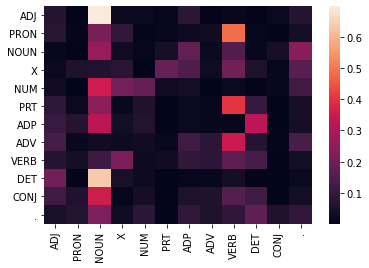

In [20]:
#sns.heatmap of tags
sns.heatmap(tags_df)
plt.show()

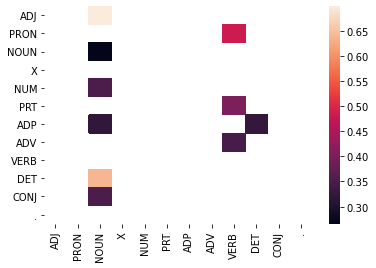

In [21]:
#frequent tags
tags_freq = tags_df[tags_df>0.25]
sns.heatmap(tags_freq)
plt.show()

In [22]:
#viterbi

def Viterbi(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            
        pmax = max(p)
        # getting state for which probability is maximum
        state_max = T[p.index(pmax)] 
        state.append(state_max)
    return list(zip(words, state))

In [23]:
#test viterbi on subset of data to save time
random.seed(3456)

#5 random sents
random_sents = [random.randint(1,len(test)) for x in range(5)]

#sents list
test_run = [test[i] for i in random_sents]

#tagged_words
test_run_base = [tup for sent in test_run for tup in sent]

#untagged words
test_tagged_words = [tup[0] for sent in test_run for tup in sent]
test_run

[[('Typical', 'ADJ'),
  ('rates', 'NOUN'),
  ('in', 'ADP'),
  ('the', 'DET'),
  ('secondary', 'ADJ'),
  ('market', 'NOUN'),
  (':', '.'),
  ('8.60', 'NUM'),
  ('%', 'NOUN'),
  ('one', 'NUM'),
  ('month', 'NOUN'),
  (';', '.'),
  ('8.55', 'NUM'),
  ('%', 'NOUN'),
  ('three', 'NUM'),
  ('months', 'NOUN'),
  (';', '.'),
  ('8.35', 'NUM'),
  ('%', 'NOUN'),
  ('six', 'NUM'),
  ('months', 'NOUN'),
  ('.', '.')],
 [('In', 'ADP'),
  ('another', 'DET'),
  ('reflection', 'NOUN'),
  ('that', 'ADP'),
  ('the', 'DET'),
  ('growth', 'NOUN'),
  ('of', 'ADP'),
  ('the', 'DET'),
  ('economy', 'NOUN'),
  ('is', 'VERB'),
  ('leveling', 'VERB'),
  ('off', 'PRT'),
  (',', '.'),
  ('the', 'DET'),
  ('government', 'NOUN'),
  ('said', 'VERB'),
  ('that', 'ADP'),
  ('orders', 'NOUN'),
  ('for', 'ADP'),
  ('manufactured', 'VERB'),
  ('goods', 'NOUN'),
  ('and', 'CONJ'),
  ('spending', 'NOUN'),
  ('on', 'ADP'),
  ('construction', 'NOUN'),
  ('failed', 'VERB'),
  ('*-1', 'X'),
  ('to', 'PRT'),
  ('rise', 'VERB'),

In [24]:
#tag test sentences 
tagged_seq = Viterbi(test_tagged_words)
print(tagged_seq)

[('Typical', 'ADJ'), ('rates', 'NOUN'), ('in', 'ADP'), ('the', 'DET'), ('secondary', 'ADJ'), ('market', 'NOUN'), (':', '.'), ('8.60', 'ADJ'), ('%', 'NOUN'), ('one', 'NUM'), ('month', 'NOUN'), (';', '.'), ('8.55', 'NUM'), ('%', 'NOUN'), ('three', 'NUM'), ('months', 'NOUN'), (';', '.'), ('8.35', 'ADJ'), ('%', 'NOUN'), ('six', 'NUM'), ('months', 'NOUN'), ('.', '.'), ('In', 'ADP'), ('another', 'DET'), ('reflection', 'NOUN'), ('that', 'ADP'), ('the', 'DET'), ('growth', 'NOUN'), ('of', 'ADP'), ('the', 'DET'), ('economy', 'NOUN'), ('is', 'VERB'), ('leveling', 'VERB'), ('off', 'PRT'), (',', '.'), ('the', 'DET'), ('government', 'NOUN'), ('said', 'VERB'), ('that', 'ADP'), ('orders', 'NOUN'), ('for', 'ADP'), ('manufactured', 'VERB'), ('goods', 'NOUN'), ('and', 'CONJ'), ('spending', 'NOUN'), ('on', 'ADP'), ('construction', 'NOUN'), ('failed', 'VERB'), ('*-1', 'X'), ('to', 'PRT'), ('rise', 'VERB'), ('in', 'ADP'), ('September', 'NOUN'), ('.', '.'), ('The', 'DET'), ('plan', 'NOUN'), ('relies', 'VERB'

In [25]:
#check accuracy
check = [i for i, j in zip(tagged_seq, test_run_base) if i == j] 
van_viterbi_acc = len(check)/len(tagged_seq)
van_viterbi_acc

0.9548872180451128

In [26]:
incorrectly_tagged = [[test_run_base[i - 1], j] for i, j in enumerate(zip(tagged_seq, test_run_base)) if j[0] != j[1]]
incorrectly_tagged

[[(':', '.'), (('8.60', 'ADJ'), ('8.60', 'NUM'))],
 [(';', '.'), (('8.35', 'ADJ'), ('8.35', 'NUM'))],
 [('$', '.'), (('2.375', 'ADJ'), ('2.375', 'NUM'))],
 [('.', '.'), (('Auctions', 'ADJ'), ('Auctions', 'NOUN'))],
 [('a', 'DET'), (('total', 'ADJ'), ('total', 'NOUN'))],
 [('$', '.'), (('25.6', 'ADJ'), ('25.6', 'NUM'))]]

In [27]:
from nltk.tokenize import word_tokenize

Read test sentence for tagging

In [28]:
test_sent = open('Test_sentences.txt',mode='r').read()
words = word_tokenize(test_sent)

tagged_seq = Viterbi(words)

vannila_test_tagged_seq = tagged_seq

print(tagged_seq)

[('Android', 'ADJ'), ('is', 'VERB'), ('a', 'DET'), ('mobile', 'ADJ'), ('operating', 'NOUN'), ('system', 'NOUN'), ('developed', 'VERB'), ('by', 'ADP'), ('Google', 'ADJ'), ('.', '.'), ('Android', 'ADJ'), ('has', 'VERB'), ('been', 'VERB'), ('the', 'DET'), ('best-selling', 'ADJ'), ('OS', 'ADJ'), ('worldwide', 'ADJ'), ('on', 'ADP'), ('smartphones', 'ADJ'), ('since', 'ADP'), ('2011', 'ADJ'), ('and', 'CONJ'), ('on', 'ADP'), ('tablets', 'NOUN'), ('since', 'ADP'), ('2013', 'ADJ'), ('.', '.'), ('Google', 'ADJ'), ('and', 'CONJ'), ('Twitter', 'ADJ'), ('made', 'VERB'), ('a', 'DET'), ('deal', 'NOUN'), ('in', 'ADP'), ('2015', 'ADJ'), ('that', 'ADP'), ('gave', 'VERB'), ('Google', 'ADJ'), ('access', 'NOUN'), ('to', 'PRT'), ('Twitter', 'ADJ'), ("'s", 'PRT'), ('firehose', 'ADJ'), ('.', '.'), ('Twitter', 'ADJ'), ('is', 'VERB'), ('an', 'DET'), ('online', 'ADJ'), ('news', 'NOUN'), ('and', 'CONJ'), ('social', 'ADJ'), ('networking', 'NOUN'), ('service', 'NOUN'), ('on', 'ADP'), ('which', 'DET'), ('users', 'NOU

### Solve the problem of unknown words

## Rule based with Viterbi 1

In [29]:
pattern = [
        (r'.*Twitter$', 'NOUN'), 
        (r'.*Android$', 'NOUN'),
        (r'.*Google$', 'NOUN'),
        (r'[-+]?\d*\.\d+|\d+', 'NUM'), # Number with floating values
        (r'.*es$', 'VERB'), 
        (r'.*ing$', 'VERB'), # gerunds or continuous tense
        (r'.*ed$', 'VERB'),  # past perfect tense
        (r'[A-Z ]+', 'NOUN'),  # all caps eg. FIFA, NASA, etc
        (r'.*', 'NOUN'), # default value as NOUN
]

def rule_based_tagging(word, pattern):
    regex_tagger = nltk.RegexpTagger(pattern)
    kv = regex_tagger.tag(nltk.word_tokenize(word))
    for v in kv:
        print(word)
        print(v[1])
        return v[1]

In [30]:
def modified_viterbi_algo(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
          
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]                
            state_probability = emission_p * transition_p    
            p.append(state_probability)
        pmax = max(p)
        if pmax == 0.0:       
            state_max = rule_based_tagging(word, pattern)
            if state_max is None :
                state_max = "."
        else :
            state_max = T[p.index(pmax)] 
        state.append(state_max)
    return list(zip(words, state))

random.seed(3456)

#5 random sents
rndom = [random.randint(1,len(test)) for x in range(5)]

#sentence list
test_run = [test[i] for i in rndom]

#tagged words
test_run_base = [tup for sent in test_run for tup in sent]

#untagged words
test_tagged_words = [tup[0] for sent in test_run for tup in sent]
test_run

#tag test sents

tagged_seq = modified_viterbi_algo(test_tagged_words)

print(tagged_seq)


Typical
NOUN
8.60
NUM
8.35
NUM
2.375
NUM
Auctions
NOUN
25.6
NUM
[('Typical', 'NOUN'), ('rates', 'NOUN'), ('in', 'ADP'), ('the', 'DET'), ('secondary', 'ADJ'), ('market', 'NOUN'), (':', '.'), ('8.60', 'NUM'), ('%', 'NOUN'), ('one', 'NUM'), ('month', 'NOUN'), (';', '.'), ('8.55', 'NUM'), ('%', 'NOUN'), ('three', 'NUM'), ('months', 'NOUN'), (';', '.'), ('8.35', 'NUM'), ('%', 'NOUN'), ('six', 'NUM'), ('months', 'NOUN'), ('.', '.'), ('In', 'ADP'), ('another', 'DET'), ('reflection', 'NOUN'), ('that', 'ADP'), ('the', 'DET'), ('growth', 'NOUN'), ('of', 'ADP'), ('the', 'DET'), ('economy', 'NOUN'), ('is', 'VERB'), ('leveling', 'VERB'), ('off', 'PRT'), (',', '.'), ('the', 'DET'), ('government', 'NOUN'), ('said', 'VERB'), ('that', 'ADP'), ('orders', 'NOUN'), ('for', 'ADP'), ('manufactured', 'VERB'), ('goods', 'NOUN'), ('and', 'CONJ'), ('spending', 'NOUN'), ('on', 'ADP'), ('construction', 'NOUN'), ('failed', 'VERB'), ('*-1', 'X'), ('to', 'PRT'), ('rise', 'VERB'), ('in', 'ADP'), ('September', 'NOUN')

#### Evaluating tagging accuracy

In [31]:
x = [i for i, j in zip(tagged_seq, test_run_base) if i == j] 
rulebased_modified_viterbi_acc = len(x)/len(tagged_seq)
print(rulebased_modified_viterbi_acc)

0.9849624060150376


In [32]:
incorrect_tags = [[test_run_base[i-1],j] for i, j in enumerate(zip(tagged_seq, test_run_base)) if j[0]!=j[1]]
incorrect_tags

[[('.', '.'), (('Typical', 'NOUN'), ('Typical', 'ADJ'))],
 [('a', 'DET'), (('total', 'ADJ'), ('total', 'NOUN'))]]

In [33]:
#display tagged seq

sentence_test = open('Test_sentences.txt',mode='r').read()
words = word_tokenize(sentence_test)

tagged_seq = modified_viterbi_algo(words)

print(tagged_seq)
rulebased_test_tag_seq = tagged_seq

Android
NOUN
Google
NOUN
Android
NOUN
OS
NOUN
worldwide
NOUN
smartphones
VERB
2011
NUM
2013
NUM
Google
NOUN
Twitter
NOUN
2015
NUM
Google
NOUN
Twitter
NOUN
firehose
NOUN
Twitter
NOUN
online
NOUN
interact
NOUN
messages
VERB
tweets
NOUN
domineering
VERB
personality
NOUN
2018
NUM
FIFA
NOUN
Cup
NOUN
21st
NUM
FIFA
NOUN
Cup
NOUN
tournament
NOUN
contested
VERB
Cup
NOUN
trips
NOUN
arriving
VERB
NASA
NOUN
invited
VERB
ICESAT-2
NOUN
Satellite
NOUN
[('Android', 'NOUN'), ('is', 'VERB'), ('a', 'DET'), ('mobile', 'ADJ'), ('operating', 'NOUN'), ('system', 'NOUN'), ('developed', 'VERB'), ('by', 'ADP'), ('Google', 'NOUN'), ('.', '.'), ('Android', 'NOUN'), ('has', 'VERB'), ('been', 'VERB'), ('the', 'DET'), ('best-selling', 'ADJ'), ('OS', 'NOUN'), ('worldwide', 'NOUN'), ('on', 'ADP'), ('smartphones', 'VERB'), ('since', 'ADP'), ('2011', 'NUM'), ('and', 'CONJ'), ('on', 'ADP'), ('tablets', 'NOUN'), ('since', 'ADP'), ('2013', 'NUM'), ('.', '.'), ('Google', 'NOUN'), ('and', 'CONJ'), ('Twitter', 'NOUN'), ('made

## Rule based viterbi 2

In [34]:
#bigram tagger
def bigram_tagger(wording) :
    t0 = DefaultTagger('NOUN')
    t1 = UnigramTagger(train_set, backoff=t0)
    t2 = BigramTagger(train_set, backoff=t1)
    listvalue=t2.tag(nltk.word_tokenize(wording))
    return listvalue[0][1]

In [35]:
def modified_viterbi_lexicon(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]

            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]                
            state_probability = emission_p * transition_p    
            p.append(state_probability)
        pmax = max(p)
        if pmax == 0.0:       
            state_max = rule_based_tagging(word, pattern)
            if state_max is None :
                state_max = "."
        else :
            state_max = T[p.index(pmax)] 
        state.append(state_max)
    return list(zip(words, state))

random.seed(3456)

#5 random sents
rndom = [random.randint(1,len(test)) for x in range(5)]

#sent list
test_run = [test[i] for i in rndom]

#tagged words
test_run_base = [tup for sent in test_run for tup in sent]

#untagged words
test_tagged_words = [tup[0] for sent in test_run for tup in sent]
test_run

#taggig
tagged_seq = modified_viterbi_lexicon(test_tagged_words)

print(tagged_seq)

Typical
NOUN
8.60
NUM
8.35
NUM
2.375
NUM
Auctions
NOUN
25.6
NUM
[('Typical', 'NOUN'), ('rates', 'NOUN'), ('in', 'ADP'), ('the', 'DET'), ('secondary', 'ADJ'), ('market', 'NOUN'), (':', '.'), ('8.60', 'NUM'), ('%', 'NOUN'), ('one', 'NUM'), ('month', 'NOUN'), (';', '.'), ('8.55', 'NUM'), ('%', 'NOUN'), ('three', 'NUM'), ('months', 'NOUN'), (';', '.'), ('8.35', 'NUM'), ('%', 'NOUN'), ('six', 'NUM'), ('months', 'NOUN'), ('.', '.'), ('In', 'ADP'), ('another', 'DET'), ('reflection', 'NOUN'), ('that', 'ADP'), ('the', 'DET'), ('growth', 'NOUN'), ('of', 'ADP'), ('the', 'DET'), ('economy', 'NOUN'), ('is', 'VERB'), ('leveling', 'VERB'), ('off', 'PRT'), (',', '.'), ('the', 'DET'), ('government', 'NOUN'), ('said', 'VERB'), ('that', 'ADP'), ('orders', 'NOUN'), ('for', 'ADP'), ('manufactured', 'VERB'), ('goods', 'NOUN'), ('and', 'CONJ'), ('spending', 'NOUN'), ('on', 'ADP'), ('construction', 'NOUN'), ('failed', 'VERB'), ('*-1', 'X'), ('to', 'PRT'), ('rise', 'VERB'), ('in', 'ADP'), ('September', 'NOUN')

In [36]:
#accuracy check
check = [i for i, j in zip(tagged_seq, test_run_base) if i == j] 
lexicon_based_viterbi_accuracy = len(check)/len(tagged_seq)
print(lexicon_based_viterbi_accuracy)

incorrect_tagged_cases = [[test_run_base[i-1],j] for i, j in enumerate(zip(tagged_seq, test_run_base)) if j[0]!=j[1]]
incorrect_tagged_cases

0.9849624060150376


[[('.', '.'), (('Typical', 'NOUN'), ('Typical', 'ADJ'))],
 [('a', 'DET'), (('total', 'ADJ'), ('total', 'NOUN'))]]

In [38]:
tagged_seq = modified_viterbi_lexicon(words)
print(tagged_seq)
lexicon_test_tag_seq = tagged_seq

Android
NOUN
Google
NOUN
Android
NOUN
OS
NOUN
worldwide
NOUN
smartphones
VERB
2011
NUM
2013
NUM
Google
NOUN
Twitter
NOUN
2015
NUM
Google
NOUN
Twitter
NOUN
firehose
NOUN
Twitter
NOUN
online
NOUN
interact
NOUN
messages
VERB
tweets
NOUN
domineering
VERB
personality
NOUN
2018
NUM
FIFA
NOUN
Cup
NOUN
21st
NUM
FIFA
NOUN
Cup
NOUN
tournament
NOUN
contested
VERB
Cup
NOUN
trips
NOUN
arriving
VERB
NASA
NOUN
invited
VERB
ICESAT-2
NOUN
Satellite
NOUN
[('Android', 'NOUN'), ('is', 'VERB'), ('a', 'DET'), ('mobile', 'ADJ'), ('operating', 'NOUN'), ('system', 'NOUN'), ('developed', 'VERB'), ('by', 'ADP'), ('Google', 'NOUN'), ('.', '.'), ('Android', 'NOUN'), ('has', 'VERB'), ('been', 'VERB'), ('the', 'DET'), ('best-selling', 'ADJ'), ('OS', 'NOUN'), ('worldwide', 'NOUN'), ('on', 'ADP'), ('smartphones', 'VERB'), ('since', 'ADP'), ('2011', 'NUM'), ('and', 'CONJ'), ('on', 'ADP'), ('tablets', 'NOUN'), ('since', 'ADP'), ('2013', 'NUM'), ('.', '.'), ('Google', 'NOUN'), ('and', 'CONJ'), ('Twitter', 'NOUN'), ('made

### Compare the tagging accuracies of the modifications with the vanilla Viterbi algorithm

In [40]:
print("Vannila Accuracy: " + str(van_viterbi_acc))
print("Lexicon Accuracy: " + str(lexicon_based_viterbi_accuracy))
print("Rule Accuracy: " + str(rulebased_modified_viterbi_acc))

Vannila Accuracy: 0.9548872180451128
Lexicon Accuracy: 0.9849624060150376
Rule Accuracy: 0.9849624060150376


### List down cases which were incorrectly tagged by original POS tagger and got corrected by your modifications

1. 'Twitter' , 'Android' are correctly tagged as noun in modified viterbi
2. Abbreviated words like 'FIFA' are tagged as noun. 
3. words ending in 'ing' and 'ed' are correctly tagged as verb.
4. words that include ints or floats are correctly tagged as 'NUM'